# Homework

## Burger's Equation

In real-world applications, the advection velocity $v$ is usually variable.  For example,

\begin{equation}
\frac{\partial U}{\partial t}+U\frac{\partial U}{\partial x}=0.
\end{equation}

This is called Burger's equation, where the advection velocity depends on the property being advected, i.e., $U$.

1)Let's try the upwind method to solve this equation with an initial Gaussian profile. (U before $\frac{\partial U}{\partial x}$ is velocity at n and j)

2)Please experiment with different grid sizes.

3)Now the solution develops a non-symmetric profile over time.  Can you explain why?

#### Math

Recall that the term $\frac{\partial U}{\partial t}$ can be written using the Lax-Freidrichs difference formula

\begin{equation}
    \frac{\partial U}{\partial t} = \frac{U_j^{n+1} - 0.5(U_{j-1}^n + U_{j+1}^n)}{\Delta t}
\end{equation}

For the spatial derivative, we will use the upwind method:

\begin{equation}
    \frac{\partial U}{\partial t} = \frac{ U_{\tilde{j}}^n - U_{\tilde{j}-1}^n }{\Delta x}
\end{equation}

where

\begin{equation}
    \tilde{j} = j~\text{if}~U_j^n>0
\end{equation}

\begin{equation}
    \tilde{j} = j+1~\text{if}~U_j^n<0
\end{equation}




so then,

\begin{equation}
    U_j^{n+1} - 0.5(U_{j-1}^n + U_{j+1}^n) = -\frac{\Delta t}{\Delta x} U_j^n ( U_{\tilde{j}}^n - U_{\tilde{j} - 1}^n )
\end{equation}

\begin{equation}
    U_j^{n+1} = -\frac{\Delta t}{\Delta x} U_j^n ( U_{\tilde{j}}^n - U_{\tilde{j} - 1}^n ) + 0.5(U_{j-1}^n + U_{j+1}^n)
\end{equation}


### HOWEVER

In the implementation below I have removed all instances of $U_j^n$ and replaced with the Lax-Friedrichs average

In [1]:
import numpy as np

def bc(j:int)->float:
    """
    Boundary condition
    """
    return 0.2

def _get_u_stable(u_old:np.ndarray,j:int,j_to_get:int):
    """
    helper to maintain stability
    
    Parameters
    ----------
    u_old : np.ndarray
        :math:`U^n`
    j : int
        The index to avoid in the Lax-Friedrichs method
    j_to_get : int
        The x index to get the value of. Proceed as normal if this
        is not j, otherwise we take a mean.
    
    Returns
    -------
    float
        :math:`U_j`
    """
    if j_to_get != j:
        return u_old[j_to_get]
    else:
        return 0.5*(u_old[j_to_get-1] + u_old[j_to_get+1])

def get_next_u(u_old:np.ndarray,j:int,dt:float,dx:float)->float:
    """
    Get :math:`U_j^{n+1}`
    
    Parameters
    ----------
    u_old : np.ndarray
        :math:`U^n`
    j : int
        The x index to evaluate at.
    dt : float
        Time step size
    dx : float
        Spatial step size
    
    Returns
    -------
    float
        :math:`U_j^{n+1}`
    """
    is_boundary = j == 0 or j == len(u_old) - 1
    if is_boundary:
        return bc(j)
    # not on the boundary --> j+1 and j-1 are valid for n
    u_jn = _get_u_stable(u_old,j,j)
    j_tilde = j if u_jn > 0 else j+1
    
    first_term = -dt/dx * _get_u_stable(u_old,j,j) * (_get_u_stable(u_old,j,j_tilde) - _get_u_stable(u_old,j,j_tilde-1))
    second_term = _get_u_stable(u_old,j,j)
    
    return first_term + second_term
    

In [2]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from copy import deepcopy

# Model Parameters
xmin = -10.0   # left boundary
xmax = +10.0   # right boundary
tend = 10.0    # end time
dtout = 1.0   # time interval for outputs

def solve(
    nx:int,
    tscale:float
):
    """
    Solve the hyperbolic PDE
    
    Parameters
    ----------
    nx : int
        Number of grid points
    tscale : float
        :math:`\Delta t/\Delta x`
    
    Returns
    -------
    x : np.ndarray
        Spatial grid
    ts : np.ndarray
        Time grid
    Us : np.ndarray
        The solution
    """
    x = np.linspace(xmin, xmax, nx)
    dx = (xmax - xmin) / (nx - 1)
    dt = tscale * dx
    
    t = 0.0
    U_init = 0.2 + 0.8 * np.exp(-0.5 * x**2)
    Us = [U_init]
    ts = [0]

    while t < tend:
        if t+dt > tend:
            _dt = tend - t
        else:
            _dt = dt
        _U = np.zeros_like(U_init)
        for j in range(0,nx):
            _U[j] = get_next_u(Us[-1],j,_dt,dx)
        t += dt
        Us.append(_U)
        ts.append(t)
    Us = np.array(Us)
    ts = np.array(ts)
    return x, ts, Us

#### Nominal case

Text(0, 0.5, '$x$')

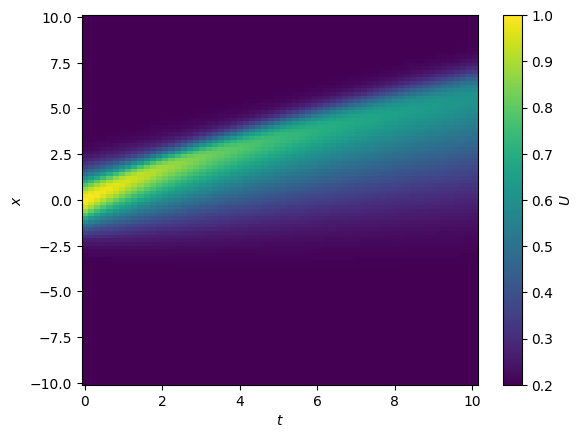

In [3]:
x,t,U = solve(101,0.8)
im = plt.pcolormesh(t,x,U.T)
plt.colorbar(im,ax=plt.gca(),label='$U$')
plt.xlabel('$t$')
plt.ylabel('$x$')

#### Low timestep

There is too much diffusion in this case

Text(0, 0.5, '$x$')

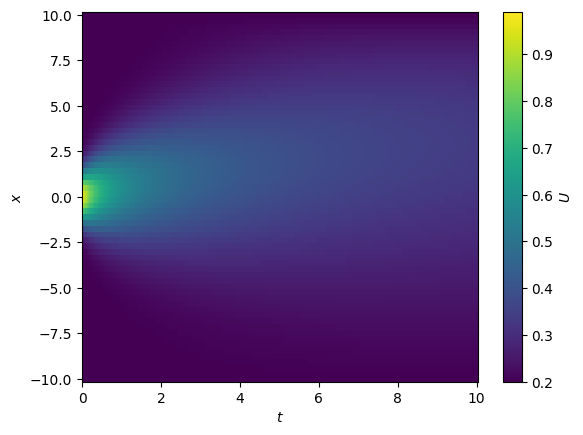

In [4]:
x,t,U = solve(64,0.1)
im = plt.pcolormesh(t,x,U.T)
plt.colorbar(im,ax=plt.gca(),label='$U$')
plt.xlabel('$t$')
plt.ylabel('$x$')

#### Larger timestep

Notice how in the plot below there are points $>1$. This is not physical as the profile is expected to diffuse. This solution is on the verge of divergence.

Text(0, 0.5, '$x$')

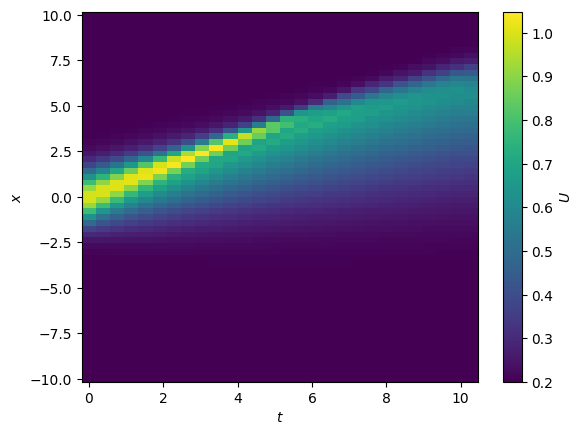

In [5]:
x,t,U = solve(64,1.2)
im = plt.pcolormesh(t,x,U.T)
plt.colorbar(im,ax=plt.gca(),label='$U$')
plt.xlabel('$t$')
plt.ylabel('$x$')

#### Example of divergence

Here we slightly increased the timestep. Note the log scale.

/tmp/ipykernel_10495/3923339954.py:2: RuntimeWarning: invalid value encountered in log10
  im = plt.pcolormesh(t,x,np.log10(U.T))


Text(0, 0.5, '$x$')

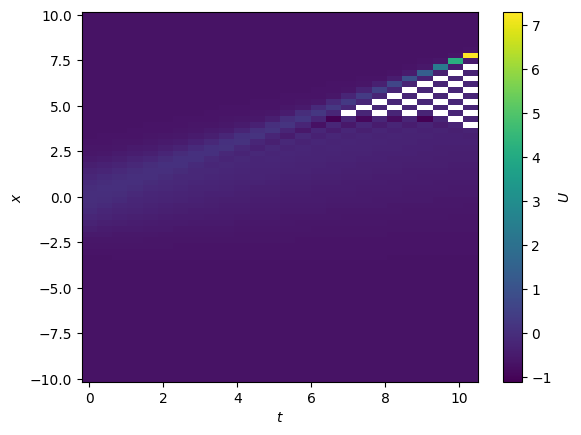

In [6]:
x,t,U = solve(64,1.3)
im = plt.pcolormesh(t,x,np.log10(U.T))
plt.colorbar(im,ax=plt.gca(),label='$U$')
plt.xlabel('$t$')
plt.ylabel('$x$')

#### Very course grid

Text(0, 0.5, '$x$')

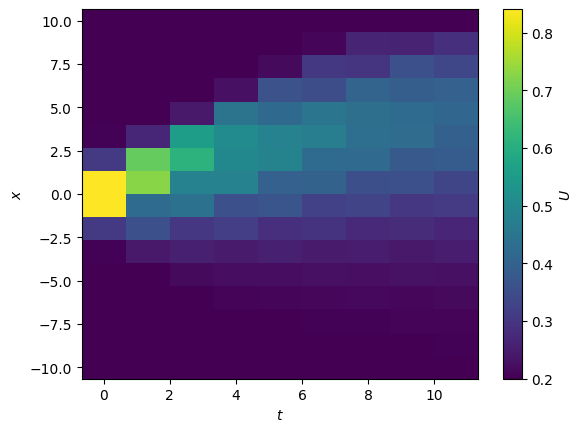

In [7]:
x,t,U = solve(16,1)
im = plt.pcolormesh(t,x,(U.T))
plt.colorbar(im,ax=plt.gca(),label='$U$')
plt.xlabel('$t$')
plt.ylabel('$x$')

#### Very fine grid

Text(0, 0.5, '$x$')

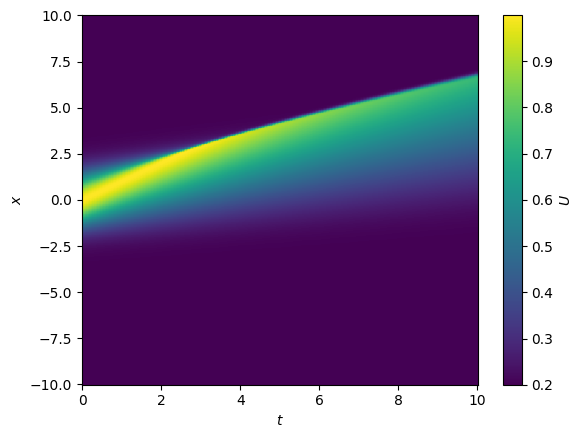

In [8]:
x,t,U = solve(512,1)
im = plt.pcolormesh(t,x,(U.T))
plt.colorbar(im,ax=plt.gca(),label='$U$')
plt.xlabel('$t$')
plt.ylabel('$x$')

Let's look at this profile closer

Text(0, 0.5, '$U$')

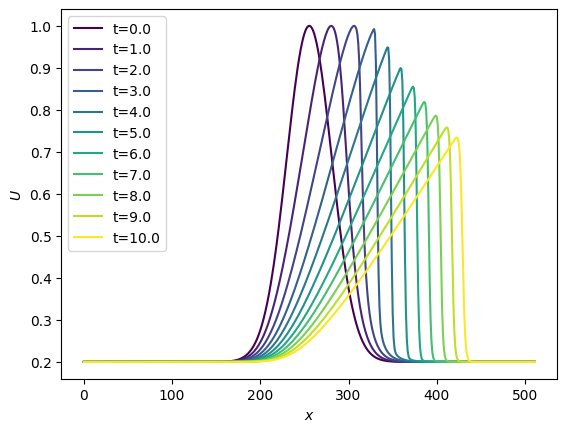

In [9]:
f = np.linspace(0,1,11)
for frac in f:
    i = int(frac*len(t))
    if i == len(t):
        i -= 1
    c = plt.get_cmap('viridis')(frac)
    plt.plot(U[i,:],c=c,label=f't={t[i]:.1f}')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$U$')

#### Why the asymmetry?

The wave profile changes as it moves because the wave speed is not constant. Specifically, the peak of the wave moves at the greatest speed as $v\sim U$.

The result is that the front edge of the wave gets sharper and sharper as it moves faster with respect to the rest of the wave packet.
